### Import libraries and add useful functions.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
w, h = 1280, 720
img_size = (w, h) # image size
nw, nh = 9, 6

In [3]:
def read_img(fname):
    # return cv2.imread(fname)
    return cv2.cvtColor(
        cv2.imread(fname),
        cv2.COLOR_BGR2RGB
    )

def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [4]:
def find_corners(img):
    return cv2.findChessboardCorners(
        grayscale(img), (nw, nh), None
    )

### Draw chessboard corners.

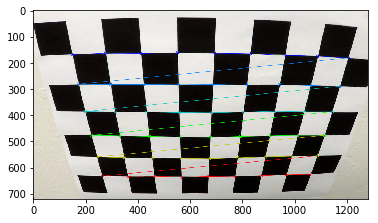

In [5]:
cal2 = read_img('camera_cal/calibration2.jpg')
success, corners = find_corners(cal2)
if success:
    cal2_copy = cal2.copy() # drawChessboardCorners modifies its parameter
    cv2.drawChessboardCorners(cal2_copy, (nw, nh), corners, True)
    plt.imshow(cal2_copy)

### Read corners from calibration images.

In [6]:
# Arrays to store object points and image points from all the images
objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane

objp = np.zeros((nw * nh, 3), np.float32)
objp[:,:2] = np.mgrid[0:nw, 0:nh].T.reshape(-1, 2) # x, y coordinate

for i in range(1, 21):
    img = read_img('camera_cal/calibration{}.jpg'.format(i))
    success, corners = find_corners(img)

    if success == True:
        imgpoints.append(corners)
        objpoints.append(objp)

### Calibrate camera.

In [7]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
    objpoints, imgpoints, img_size, None, None
)

### Create undestort, and add visualization.

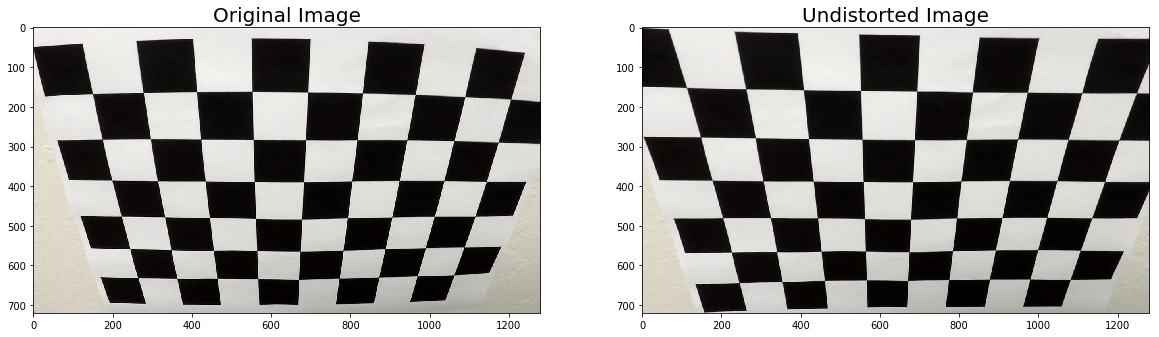

In [8]:
def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

cal2_und = undistort(cal2)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(cal2)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(cal2_und)
ax2.set_title('Undistorted Image', fontsize=20)

### Warp image *(view from top)*.

In [97]:

# define source and destination points for transform
trap = np.float32([
    (570,480),  # top left
    (780,480),  # top right
    (250,h),    # bottom left
    (1130,h)    # bottom right
])  


offset = 300
dst = np.float32([
    (offset,offset),
    (w-offset,offset),
    (offset,h),
    (w-offset,h)
])


In [98]:
def warp(img):
    M = cv2.getPerspectiveTransform(trap, dst)
    Minv = cv2.getPerspectiveTransform(dst, trap)
    return cv2.warpPerspective(img, M, img_size), Minv

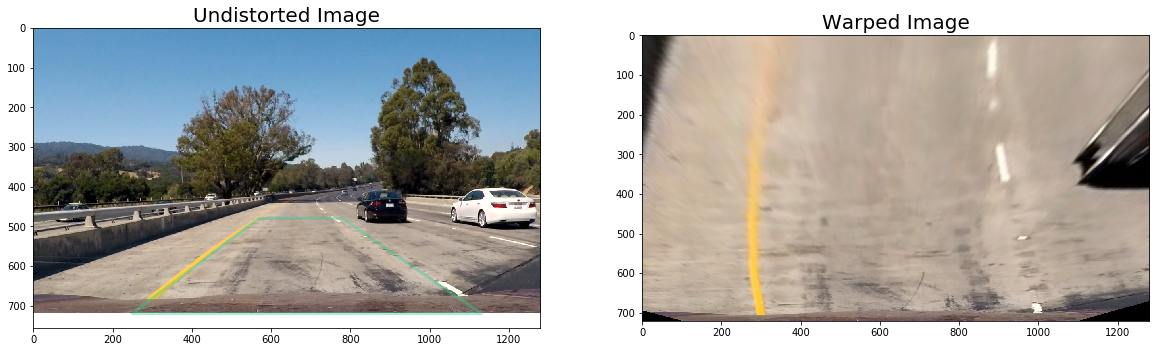

In [211]:
test_img = read_img('test_images/test1.jpg')

warped, Minv = warp(test_img)

# Visualization
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(test_img)
x = [trap[0][0],trap[2][0],trap[3][0],trap[1][0],trap[0][0]]
y = [trap[0][1],trap[2][1],trap[3][1],trap[1][1],trap[0][1]]
ax1.plot(x, y, color='#33cc99', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
ax1.set_title('Undistorted Image', fontsize=20)
ax2.imshow(warped)
ax2.set_title('Warped Image', fontsize=20)

# Gradient thresholds.

In [255]:
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(gray, orient='x', thresh_min=20, thresh_max=100):
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

In [256]:
# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(gray, sobel_kernel=3, mag_thresh=(30, 100)):
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

In [257]:
# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(gray, sobel_kernel=3, thresh=(0.7, 1.3)):
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

In [260]:
def combine_thresholds(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gradx = abs_sobel_thresh(gray, 'x')
    grady = abs_sobel_thresh(gray, 'x')
    mag_binary = mag_thresh(gray)
    dir_binary = dir_threshold(gray)
    combined_grads = np.zeros_like(gradx)
    combined_grads[(gradx == 1) | (grady == 1) & (mag_binary == 1) & (dir_binary == 1)] = 1
    # combined_grads[(grady == 1) & (mag_binary == 1) | (gradx == 1) & (dir_binary == 1)] = 1
    # combined_grads[(grady == 1) & (mag_binary == 1)] = 1
    return combined_grads

### Visualize all gradient thresholds.

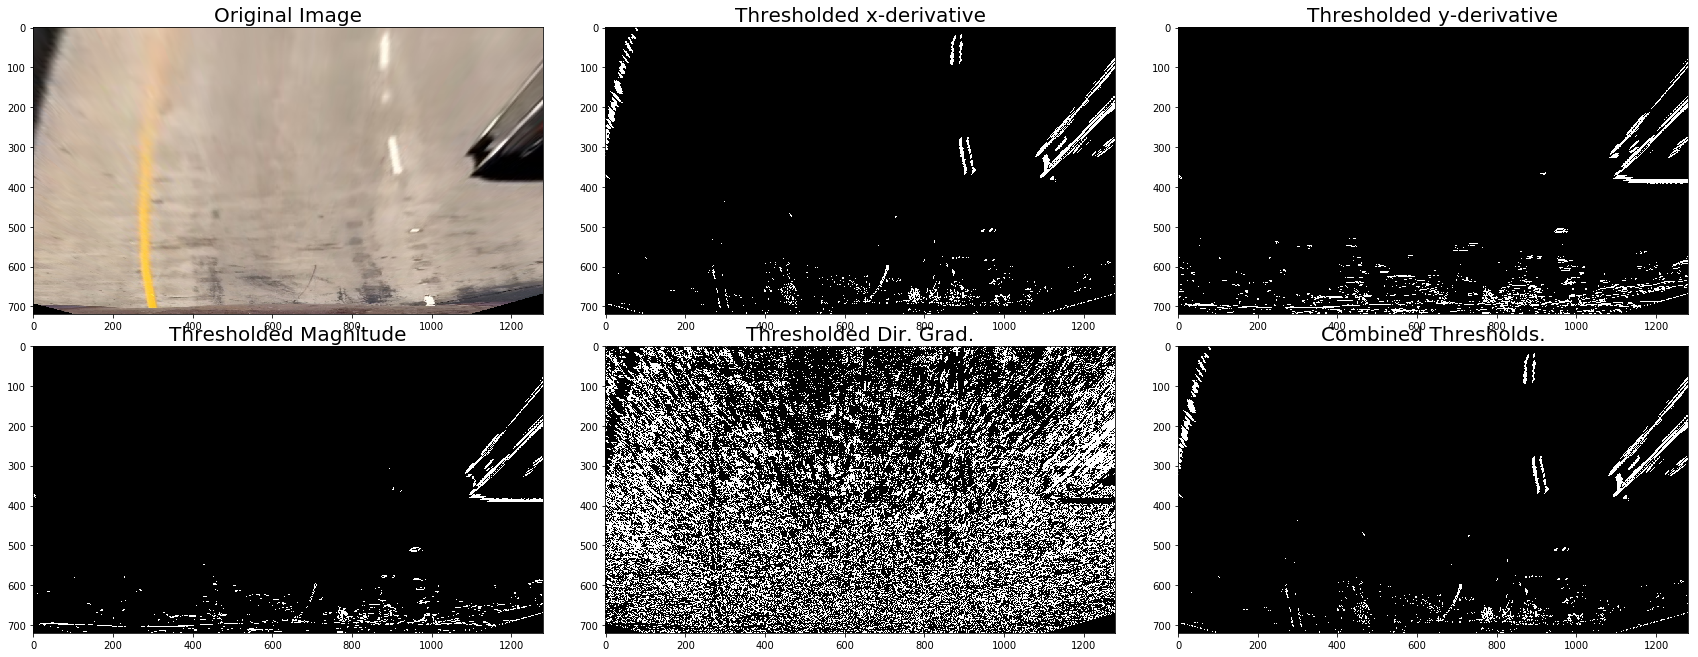

In [261]:
warped_gray = cv2.cvtColor(warped, cv2.COLOR_RGB2GRAY)

gradx = abs_sobel_thresh(warped_gray, 'x')
grady = abs_sobel_thresh(warped_gray, 'y')
mag_binary = mag_thresh(warped_gray)
dir_binary = dir_threshold(warped_gray)

combined_thresholds = combine_thresholds(warped)

f, axs = plt.subplots(2, 3, figsize=(24, 9))
f.tight_layout()
axs[0][0].imshow(warped)
axs[0][0].set_title('Original Image', fontsize=20)
axs[0][1].imshow(gradx, cmap='gray')
axs[0][1].set_title('Thresholded x-derivative', fontsize=20)
axs[0][2].imshow(grady, cmap='gray')
axs[0][2].set_title('Thresholded y-derivative', fontsize=20)
axs[1][0].imshow(mag_binary, cmap='gray')
axs[1][0].set_title('Thresholded Magnitude', fontsize=20)
axs[1][1].imshow(dir_binary, cmap='gray')
axs[1][1].set_title('Thresholded Dir. Grad.', fontsize=20)
axs[1][2].imshow(combined_thresholds, cmap='gray')
axs[1][2].set_title('Combined Thresholds.', fontsize=20)

# Color spaces.

In [262]:
def print_channels(imgs, labels):
    f, axs = plt.subplots(1, 3, figsize=(20,10))
    for i in range(3):
        axs[i].set_title(labels[i], fontsize=20)
        axs[i].imshow(imgs[i], cmap='gray')

### RGB.

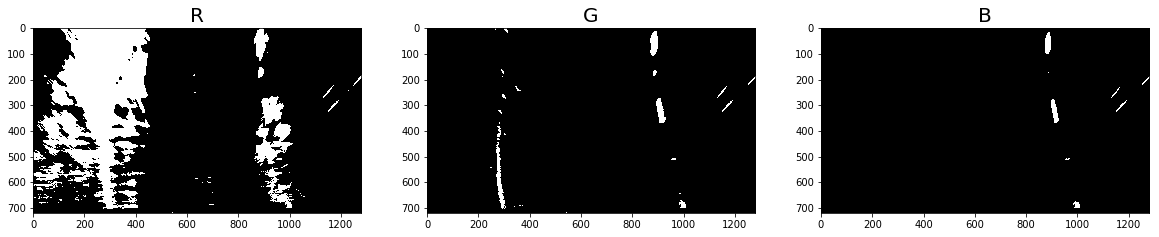

In [263]:
def rgb_channels(img):
    images = []
    for i in range(3):
        im = img[:,:,i]
        binary = np.zeros_like(im)
        binary[(im > 200) & (im <= 255)] = 1
        images.append(binary)
    return images

print_channels(rgb_channels(warped), ['R','G','B'])

### HLS.

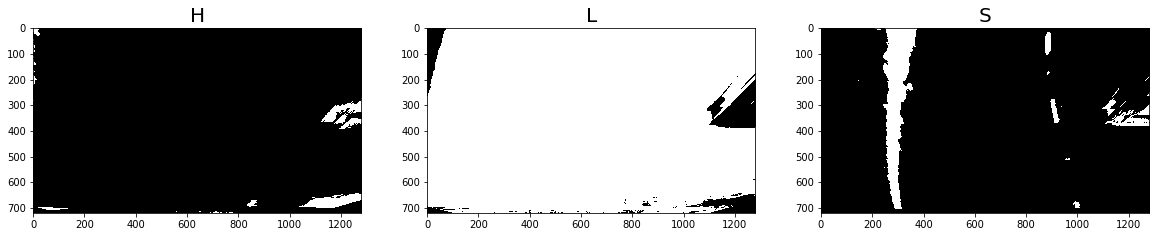

In [264]:
def hls_channels(img):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    images = []
    for i in range(3):
        im = hls[:,:,i]
        binary = np.zeros_like(im)
        binary[(im > 90) & (im <= 255)] = 1
        images.append(binary)
    return images

print_channels(hls_channels(warped), ['H','L','S'])

### HSV.

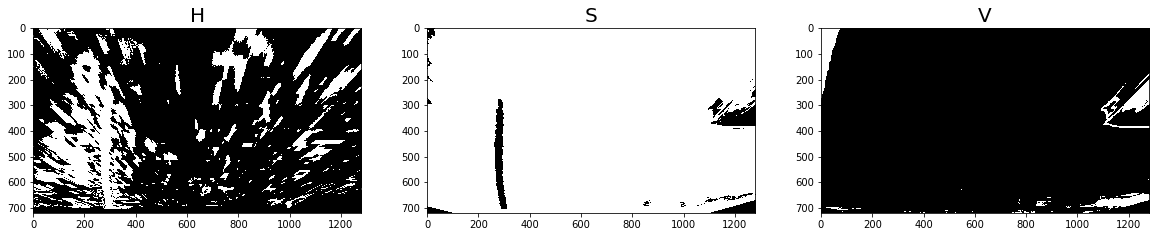

In [265]:
def hsv_channels(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    images = []
    for i in range(3):
        im = hsv[:,:,i]
        binary = np.zeros_like(im)
        binary[(im > 15) & (im <= 100)] = 1
        images.append(binary)
    return images

print_channels(hsv_channels(warped), ['H','S','V'])

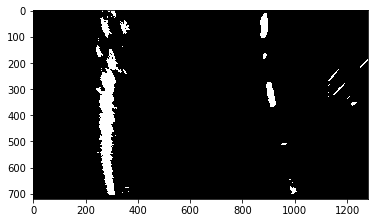

In [266]:
def combine_colors(img):
    [r,g,b] = rgb_channels(img)
    s = hls_channels(img)[2]
    h = hsv_channels(img)[0]
    combined = np.zeros_like(r)
    combined[((r == 1) & (g == 1)) | ((s == 1) & (h == 1))] = 1
    return combined
    
combined_colors = combine_colors(warped)
plt.imshow(combined_colors, cmap='gray')

## Combine color space and gradient threshold.

In [267]:
def combine_both(img):
    combined_thresholds = combine_thresholds(img)
    combined_colors = combine_colors(img)
    combined_both = np.zeros_like(combined_colors)
    combined_both[((combined_colors == 1) | (combined_thresholds == 1))] = 1
    return combined_both

### Visualize combination.

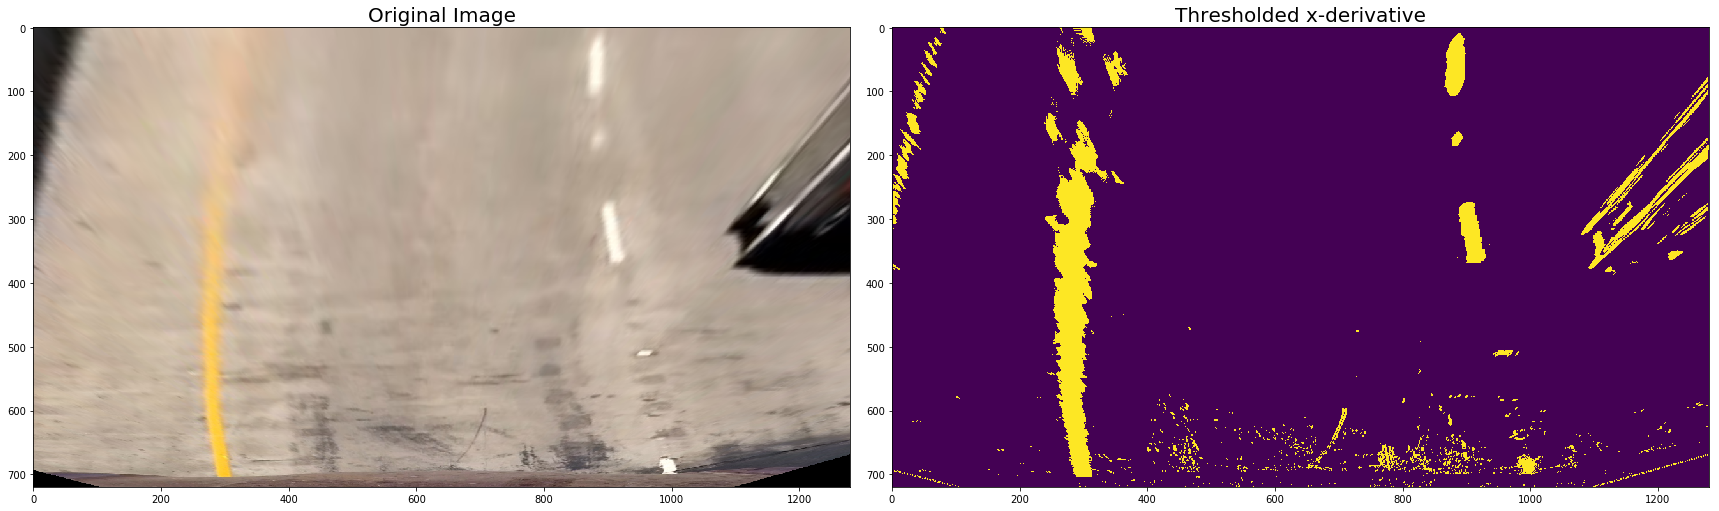

In [306]:
combined_both = combine_both(warped)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(warped)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(combined_both)
ax2.set_title('Thresholded x-derivative', fontsize=20)

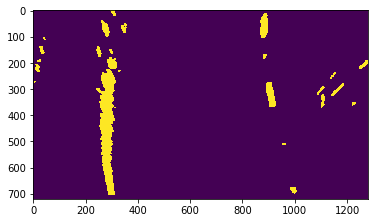

In [307]:
def remove_impurities(binary_img):
    BW = binary_img
    minThick = 8 # Define minimum thickness
    se = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (minThick,minThick)) # define a disk element
    finalBW = 255*cv2.morphologyEx(BW.astype('uint8'), cv2.MORPH_OPEN, se) # "chop" half thickness from mask and dilate the eroded mask
    return finalBW
    # Find invalid area
    # invalidArea = 255*np.logical_and(BW, np.logical_not(finalBW)).astype('uint8') 
    # plt.imshow(finalBW)
    # combined_both = finalBW
    
bin_img = remove_impurities(combined_both)
plt.imshow(bin_img)

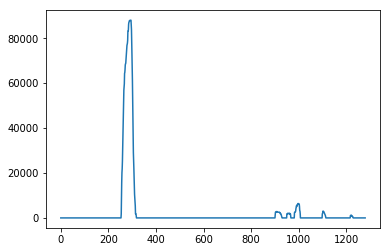

In [308]:
histogram = np.sum(bin_img[bin_img.shape[0]//2:,:], axis=0)
plt.plot(histogram)

In [309]:
def get_sliding_windows(binary_img):
    binary_warped = binary_img.copy()
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[h//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 12
    # Set height of windows
    window_height = np.int(h/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return (out_img, left_fit, right_fit, nonzeroy, nonzerox, left_lane_inds, right_lane_inds)

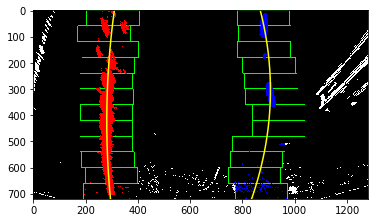

In [271]:
def visualize_sliding_windows(binary_warped, sliding_windows):
    (out_img, left_fit, right_fit, nonzeroy, nonzerox,
     left_lane_inds, right_lane_inds
    ) = sliding_windows
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    # plt.xlim(0, 1280)
    # plt.ylim(720, 0)left_lane_inds

    
sliding_windows = get_sliding_windows(combined_both)

visualize_sliding_windows(combined_both, sliding_windows)

In [116]:
def get_next_sliding_windows(binary_img, left_fit, right_fit):
    binary_warped = binary_img.copy()
    
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    return (ploty, left_fitx, right_fitx, left_fit, right_fit, nonzeroy, nonzerox, left_lane_inds, right_lane_inds, margin)

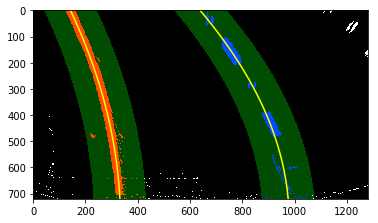

In [117]:
def visualize_next_sliding_windows(binary_warped, next_sliding_windows):
    (ploty, left_fitx, right_fitx, left_fit, right_fit, nonzeroy, nonzerox, left_lane_inds, right_lane_inds, margin) = next_sliding_windows
    # Create an image to draw on and an image to show the selectinonzeroyon window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0, 255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0, 255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    

left_fit = sliding_windows[1]
right_fit = sliding_windows[2]
next_sliding_windows = get_next_sliding_windows(combined_both, left_fit, right_fit)

visualize_next_sliding_windows(combined_both, next_sliding_windows)

In [118]:
# def measure_curvature():
#     # Generate some fake data to represent lane-line pixels
#     ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
#     quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
#     # For each y position generate random x position within +/-50 pix
#     # of the line base position in each case (x=200 for left, and x=900 for right)
#     leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
#                                   for y in ploty])
#     rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
#                                     for y in ploty])

#     leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
#     rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


#     # Fit a second order polynomial to pixel positions in each fake lane line
#     left_fit = np.polyfit(ploty, leftx, 2)
#     left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
#     right_fit = np.polyfit(ploty, rightx, 2)
#     right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

#     # Plot up the fake data
#     mark_size = 3
#     plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
#     plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
#     plt.xlim(0, 1280)
#     plt.ylim(0, 720)
#     plt.plot(left_fitx, ploty, color='green', linewidth=3)
#     plt.plot(right_fitx, ploty, color='green', linewidth=3)
#     plt.gca().invert_yaxis() # to visualize as we do the images
#     return ploty
    
    
# ploty = measure_curvature()

In [119]:

# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
# y_eval = np.max(ploty)
# left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
# right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
# print(left_curverad, right_curverad)
# Example values: 1926.74 1908.48


In [120]:


# Method to determine radius of curvature and distance from lane center 
# based on binary image, polynomial fit, and L and R lane pixel indices
def calc_curv_rad_and_center_dist(bin_img, l_fit, r_fit, l_lane_inds, r_lane_inds):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension, lane line is 10 ft = 3.048 meters
    xm_per_pix = 3.7/700 # meters per pixel in x dimension, lane width is 12 ft = 3.7 meters
    left_curverad, right_curverad, center_dist = (0, 0, 0)
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image

    ploty = np.linspace(0, h-1, h)
    y_eval = np.max(ploty)
  
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = bin_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Again, extract left and right line pixel positions
    leftx = nonzerox[l_lane_inds]
    lefty = nonzeroy[l_lane_inds] 
    rightx = nonzerox[r_lane_inds]
    righty = nonzeroy[r_lane_inds]
    
    if len(leftx) != 0 and len(rightx) != 0:
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters
    
    # Distance from center is image x midpoint - mean of l_fit and r_fit intercepts 
    if r_fit is not None and l_fit is not None:
        car_position = bin_img.shape[1]/2
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        lane_center_position = (r_fit_x_int + l_fit_x_int) /2
        center_dist = (car_position - lane_center_position) * xm_per_pix
    return left_curverad, right_curverad, center_dist





In [121]:
# next_sliding_windows
left_lane_inds = next_sliding_windows[7]
right_lane_inds = next_sliding_windows[8]
ploty = None
rad_l, rad_r, d_center = calc_curv_rad_and_center_dist(
    combined_both, left_fit, right_fit, left_lane_inds, right_lane_inds
)

print('Radius of curvature for example:', rad_l, 'm,', rad_r, 'm')
print('Distance from lane center for example:', d_center, 'm')



Radius of curvature for example: 563.159105559 m, 313.192296609 m
Distance from lane center for example: -0.0387753545295 m


In [122]:
# def draw_lane(original_img, binary_img, l_fit, r_fit, Minv):
#     new_img = np.copy(original_img)
#     if l_fit is None or r_fit is None:
#         return original_img
#     # Create an image to draw the lines on
#     warp_zero = np.zeros_like(binary_img).astype(np.uint8)
#     color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
#     h,w = binary_img.shape
#     ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
#     left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
#     right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]

#     # Recast the x and y points into usable format for cv2.fillPoly()
#     pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
#     pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
#     pts = np.hstack((pts_left, pts_right))

#     # Draw the lane onto the warped blank image
#     cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
#     cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
#     cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

#     # Warp the blank back to original image space using inverse perspective matrix (Minv)
#     newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
#     # Combine the result with the original image
#     result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
#     return result

In [123]:
# exampleImg_out1 = draw_lane(test_img, combined_both, left_fit, right_fit, Minv)
# plt.imshow(exampleImg_out1)

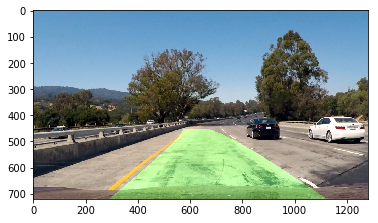

In [240]:
ploty = next_sliding_windows[0]
left_fitx = next_sliding_windows[1]
right_fitx = next_sliding_windows[2]

# wa
# Create an image to draw the lines on
# plt.imshow(test_image)
warp_zero = np.zeros_like(combined_both).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
plt.imshow(color_warp)
# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, img_size) 
# Combine the result with the original image
result = cv2.addWeighted(test_img, 1, newwarp, 0.3, 0)
plt.imshow(result)

In [166]:
def fill_area(initial_img, binary_img, ploty, left_fitx, right_fitx):
    #     ploty = wins[0]
    #     left_fitx = wins[1]
    #     right_fitx = wins[2]

    # wa
    # Create an image to draw the lines on
    # plt.imshow(test_image)
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # plt.imshow(color_warp)
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, img_size) 
    # Combine the result with the original image
    result = cv2.addWeighted(initial_img, 1, newwarp, 0.3, 0)
    return result

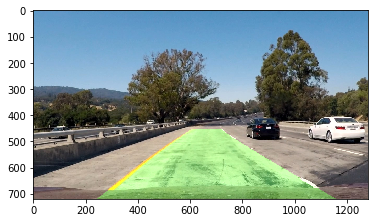

In [312]:
init = None

def process_img(img):
    return pipeline(img)

def pipeline(img):
    # plt.imshow(img)
    global initial
    global left_fit
    global right_fit
    global left_fitx
    global right_fitx

    p_und = undistort(img)
    p_warped, M_inv = warp(p_und)
    comba = combine_both(p_warped)
    comb = remove_impurities(comba)
    # plt.imshow(comb)
    # print(initial)
    if initial == True:
        sliding_windows = get_sliding_windows(comb)
        left_fit = sliding_windows[1]
        right_fit = sliding_windows[2]
        initial = False
        left_fitx = None
        right_fitx = None

    wins = get_next_sliding_windows(comb, left_fit, right_fit)
    ploty = wins[0]
    left_fitx = wins[1] if left_fitx is None else (wins[1] + left_fitx*3)/4
    right_fitx = wins[2] if right_fitx is None else (wins[2] + right_fitx*3)/4

    ff = fill_area(img, comb, ploty, left_fitx, right_fitx)
    return ff

initial = True
aa = read_img('test_images/test1.jpg')
# plt.imshow(aa)
t = pipeline(aa)
plt.imshow(t)

In [314]:
from moviepy.editor import VideoFileClip

    
 
video_output = 'result.mp4'
initial = True
clip1 = VideoFileClip("project_video.mp4") # .subclip(0,1)
white_clip = clip1.fl_image(process_img) 
white_clip.write_videofile(video_output, audio=False)
# pipeline(test_img)

[MoviePy] >>>> Building video result.mp4
[MoviePy] Writing video result.mp4




  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 1/1261 [00:00<04:02,  5.20it/s]

  0%|          | 2/1261 [00:00<03:58,  5.27it/s]

  0%|          | 3/1261 [00:00<03:57,  5.30it/s]

  0%|          | 4/1261 [00:00<03:45,  5.58it/s]

  0%|          | 5/1261 [00:00<03:37,  5.78it/s]

  0%|          | 6/1261 [00:01<03:31,  5.94it/s]

  1%|          | 7/1261 [00:01<03:34,  5.86it/s]

  1%|          | 8/1261 [00:01<03:29,  5.99it/s]

  1%|          | 9/1261 [00:01<03:28,  6.02it/s]

  1%|          | 10/1261 [00:01<03:24,  6.10it/s]

  1%|          | 11/1261 [00:01<03:23,  6.13it/s]

  1%|          | 12/1261 [00:02<03:21,  6.19it/s]

  1%|          | 13/1261 [00:02<03:25,  6.09it/s]

  1%|          | 14/1261 [00:02<03:23,  6.13it/s]

  1%|          | 15/1261 [00:02<03:21,  6.18it/s]

  1%|▏         | 16/1261 [00:02<03:20,  6.21it/s]

  1%|▏         | 17/1261 [00:02<03:20,  6.20it/s]

  1%|▏         | 18/1261 [00:02<03:22,  6.13it/s]

  2%|▏         | 19/1261 [00:03<03:22,  6.14it/

 11%|█▏        | 143/1261 [00:25<03:24,  5.47it/s]

 11%|█▏        | 144/1261 [00:25<03:30,  5.32it/s]

 11%|█▏        | 145/1261 [00:25<03:29,  5.32it/s]

 12%|█▏        | 146/1261 [00:25<03:21,  5.53it/s]

 12%|█▏        | 147/1261 [00:25<03:18,  5.61it/s]

 12%|█▏        | 148/1261 [00:25<03:24,  5.45it/s]

 12%|█▏        | 149/1261 [00:26<03:24,  5.44it/s]

 12%|█▏        | 150/1261 [00:26<03:20,  5.55it/s]

 12%|█▏        | 151/1261 [00:26<03:15,  5.67it/s]

 12%|█▏        | 152/1261 [00:26<03:12,  5.76it/s]

 12%|█▏        | 153/1261 [00:26<03:15,  5.65it/s]

 12%|█▏        | 154/1261 [00:27<03:12,  5.76it/s]

 12%|█▏        | 155/1261 [00:27<03:12,  5.76it/s]

 12%|█▏        | 156/1261 [00:27<03:17,  5.59it/s]

 12%|█▏        | 157/1261 [00:27<03:19,  5.53it/s]

 13%|█▎        | 158/1261 [00:27<03:14,  5.68it/s]

 13%|█▎        | 159/1261 [00:27<03:09,  5.80it/s]

 13%|█▎        | 160/1261 [00:28<03:12,  5.73it/s]

 13%|█▎        | 161/1261 [00:28<03:14,  5.65it/s]

 13%|█▎     

 23%|██▎       | 284/1261 [00:50<02:48,  5.79it/s]

 23%|██▎       | 285/1261 [00:50<02:49,  5.76it/s]

 23%|██▎       | 286/1261 [00:50<02:46,  5.84it/s]

 23%|██▎       | 287/1261 [00:50<02:46,  5.86it/s]

 23%|██▎       | 288/1261 [00:50<02:50,  5.70it/s]

 23%|██▎       | 289/1261 [00:50<02:52,  5.62it/s]

 23%|██▎       | 290/1261 [00:51<02:50,  5.70it/s]

 23%|██▎       | 291/1261 [00:51<02:44,  5.88it/s]

 23%|██▎       | 292/1261 [00:51<02:44,  5.90it/s]

 23%|██▎       | 293/1261 [00:51<02:45,  5.85it/s]

 23%|██▎       | 294/1261 [00:51<02:41,  5.99it/s]

 23%|██▎       | 295/1261 [00:51<02:42,  5.96it/s]

 23%|██▎       | 296/1261 [00:52<02:41,  5.99it/s]

 24%|██▎       | 297/1261 [00:52<02:38,  6.06it/s]

 24%|██▎       | 298/1261 [00:52<02:43,  5.90it/s]

 24%|██▎       | 299/1261 [00:52<02:43,  5.88it/s]

 24%|██▍       | 300/1261 [00:52<02:42,  5.91it/s]

 24%|██▍       | 301/1261 [00:52<02:42,  5.89it/s]

 24%|██▍       | 302/1261 [00:53<02:50,  5.63it/s]

 24%|██▍    

 34%|███▎      | 425/1261 [01:15<02:26,  5.72it/s]

 34%|███▍      | 426/1261 [01:15<02:29,  5.59it/s]

 34%|███▍      | 427/1261 [01:15<02:31,  5.50it/s]

 34%|███▍      | 428/1261 [01:15<02:26,  5.68it/s]

 34%|███▍      | 429/1261 [01:15<02:25,  5.74it/s]

 34%|███▍      | 430/1261 [01:15<02:21,  5.87it/s]

 34%|███▍      | 431/1261 [01:16<02:26,  5.67it/s]

 34%|███▍      | 432/1261 [01:16<02:26,  5.68it/s]

 34%|███▍      | 433/1261 [01:16<02:22,  5.80it/s]

 34%|███▍      | 434/1261 [01:16<02:28,  5.59it/s]

 34%|███▍      | 435/1261 [01:16<02:30,  5.48it/s]

 35%|███▍      | 436/1261 [01:16<02:26,  5.63it/s]

 35%|███▍      | 437/1261 [01:17<02:24,  5.69it/s]

 35%|███▍      | 438/1261 [01:17<02:25,  5.67it/s]

 35%|███▍      | 439/1261 [01:17<02:20,  5.84it/s]

 35%|███▍      | 440/1261 [01:17<02:19,  5.89it/s]

 35%|███▍      | 441/1261 [01:17<02:21,  5.80it/s]

 35%|███▌      | 442/1261 [01:18<02:27,  5.56it/s]

 35%|███▌      | 443/1261 [01:18<02:30,  5.44it/s]

 35%|███▌   

 45%|████▍     | 566/1261 [01:40<02:10,  5.33it/s]

 45%|████▍     | 567/1261 [01:40<02:08,  5.42it/s]

 45%|████▌     | 568/1261 [01:40<02:14,  5.17it/s]

 45%|████▌     | 569/1261 [01:40<02:15,  5.11it/s]

 45%|████▌     | 570/1261 [01:41<02:11,  5.24it/s]

 45%|████▌     | 571/1261 [01:41<02:08,  5.39it/s]

 45%|████▌     | 572/1261 [01:41<02:10,  5.26it/s]

 45%|████▌     | 573/1261 [01:41<02:10,  5.28it/s]

 46%|████▌     | 574/1261 [01:41<02:08,  5.35it/s]

 46%|████▌     | 575/1261 [01:41<02:06,  5.41it/s]

 46%|████▌     | 576/1261 [01:42<02:09,  5.31it/s]

 46%|████▌     | 577/1261 [01:42<02:08,  5.31it/s]

 46%|████▌     | 578/1261 [01:42<02:02,  5.56it/s]

 46%|████▌     | 579/1261 [01:42<02:02,  5.56it/s]

 46%|████▌     | 580/1261 [01:42<02:06,  5.37it/s]

 46%|████▌     | 581/1261 [01:43<02:08,  5.28it/s]

 46%|████▌     | 582/1261 [01:43<02:06,  5.38it/s]

 46%|████▌     | 583/1261 [01:43<02:04,  5.44it/s]

 46%|████▋     | 584/1261 [01:43<02:11,  5.14it/s]

 46%|████▋  

 56%|█████▌    | 707/1261 [02:05<01:40,  5.52it/s]

 56%|█████▌    | 708/1261 [02:06<01:37,  5.67it/s]

 56%|█████▌    | 709/1261 [02:06<01:38,  5.59it/s]

 56%|█████▋    | 710/1261 [02:06<01:38,  5.57it/s]

 56%|█████▋    | 711/1261 [02:06<01:35,  5.74it/s]

 56%|█████▋    | 712/1261 [02:06<01:33,  5.86it/s]

 57%|█████▋    | 713/1261 [02:06<01:37,  5.63it/s]

 57%|█████▋    | 714/1261 [02:07<01:37,  5.59it/s]

 57%|█████▋    | 715/1261 [02:07<01:34,  5.79it/s]

 57%|█████▋    | 716/1261 [02:07<01:32,  5.92it/s]

 57%|█████▋    | 717/1261 [02:07<01:38,  5.55it/s]

 57%|█████▋    | 718/1261 [02:07<01:39,  5.48it/s]

 57%|█████▋    | 719/1261 [02:08<01:35,  5.66it/s]

 57%|█████▋    | 720/1261 [02:08<01:33,  5.79it/s]

 57%|█████▋    | 721/1261 [02:08<01:34,  5.71it/s]

 57%|█████▋    | 722/1261 [02:08<01:35,  5.67it/s]

 57%|█████▋    | 723/1261 [02:08<01:32,  5.82it/s]

 57%|█████▋    | 724/1261 [02:08<01:30,  5.94it/s]

 57%|█████▋    | 725/1261 [02:09<01:34,  5.69it/s]

 58%|█████▊ 

 67%|██████▋   | 848/1261 [02:30<01:12,  5.69it/s]

 67%|██████▋   | 849/1261 [02:31<01:13,  5.63it/s]

 67%|██████▋   | 850/1261 [02:31<01:14,  5.49it/s]

 67%|██████▋   | 851/1261 [02:31<01:14,  5.52it/s]

 68%|██████▊   | 852/1261 [02:31<01:11,  5.69it/s]

 68%|██████▊   | 853/1261 [02:31<01:10,  5.80it/s]

 68%|██████▊   | 854/1261 [02:31<01:12,  5.63it/s]

 68%|██████▊   | 855/1261 [02:32<01:12,  5.62it/s]

 68%|██████▊   | 856/1261 [02:32<01:09,  5.82it/s]

 68%|██████▊   | 857/1261 [02:32<01:09,  5.84it/s]

 68%|██████▊   | 858/1261 [02:32<01:07,  5.99it/s]

 68%|██████▊   | 859/1261 [02:32<01:09,  5.82it/s]

 68%|██████▊   | 860/1261 [02:32<01:08,  5.87it/s]

 68%|██████▊   | 861/1261 [02:33<01:08,  5.86it/s]

 68%|██████▊   | 862/1261 [02:33<01:12,  5.53it/s]

 68%|██████▊   | 863/1261 [02:33<01:12,  5.49it/s]

 69%|██████▊   | 864/1261 [02:33<01:10,  5.62it/s]

 69%|██████▊   | 865/1261 [02:33<01:09,  5.68it/s]

 69%|██████▊   | 866/1261 [02:34<01:12,  5.46it/s]

 69%|██████▉

 78%|███████▊  | 989/1261 [02:55<00:50,  5.41it/s]

 79%|███████▊  | 990/1261 [02:55<00:49,  5.49it/s]

 79%|███████▊  | 991/1261 [02:56<00:48,  5.58it/s]

 79%|███████▊  | 992/1261 [02:56<00:48,  5.57it/s]

 79%|███████▊  | 993/1261 [02:56<00:47,  5.68it/s]

 79%|███████▉  | 994/1261 [02:56<00:46,  5.73it/s]

 79%|███████▉  | 995/1261 [02:56<00:46,  5.67it/s]

 79%|███████▉  | 996/1261 [02:57<00:50,  5.24it/s]

 79%|███████▉  | 997/1261 [02:57<00:49,  5.37it/s]

 79%|███████▉  | 998/1261 [02:57<00:47,  5.50it/s]

 79%|███████▉  | 999/1261 [02:57<00:47,  5.56it/s]

 79%|███████▉  | 1000/1261 [02:57<00:46,  5.66it/s]

 79%|███████▉  | 1001/1261 [02:57<00:47,  5.50it/s]

 79%|███████▉  | 1002/1261 [02:58<00:46,  5.58it/s]

 80%|███████▉  | 1003/1261 [02:58<00:45,  5.62it/s]

 80%|███████▉  | 1004/1261 [02:58<00:46,  5.50it/s]

 80%|███████▉  | 1005/1261 [02:58<00:47,  5.44it/s]

 80%|███████▉  | 1006/1261 [02:58<00:47,  5.36it/s]

 80%|███████▉  | 1007/1261 [02:59<00:48,  5.26it/s]

 80%

 89%|████████▉ | 1128/1261 [03:21<00:24,  5.51it/s]

 90%|████████▉ | 1129/1261 [03:21<00:23,  5.60it/s]

 90%|████████▉ | 1130/1261 [03:21<00:22,  5.75it/s]

 90%|████████▉ | 1131/1261 [03:21<00:22,  5.82it/s]

 90%|████████▉ | 1132/1261 [03:22<00:22,  5.68it/s]

 90%|████████▉ | 1133/1261 [03:22<00:22,  5.70it/s]

 90%|████████▉ | 1134/1261 [03:22<00:21,  5.79it/s]

 90%|█████████ | 1135/1261 [03:22<00:22,  5.54it/s]

 90%|█████████ | 1136/1261 [03:22<00:22,  5.53it/s]

 90%|█████████ | 1137/1261 [03:23<00:21,  5.64it/s]

 90%|█████████ | 1138/1261 [03:23<00:21,  5.67it/s]

 90%|█████████ | 1139/1261 [03:23<00:21,  5.78it/s]

 90%|█████████ | 1140/1261 [03:23<00:21,  5.72it/s]

 90%|█████████ | 1141/1261 [03:23<00:20,  5.81it/s]

 91%|█████████ | 1142/1261 [03:23<00:20,  5.85it/s]

 91%|█████████ | 1143/1261 [03:24<00:20,  5.74it/s]

 91%|█████████ | 1144/1261 [03:24<00:20,  5.68it/s]

 91%|█████████ | 1145/1261 [03:24<00:20,  5.79it/s]

 91%|█████████ | 1146/1261 [03:24<00:19,  5.89

[MoviePy] Done.
[MoviePy] >>>> Video ready: result.mp4 

